<a href="https://colab.research.google.com/github/Mpho-AI/ML---Predicting-Co2-Emissions-of-cars/blob/main/potato_disease_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potato Disease Classification

Dataset obtained from: https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=25

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Bradford/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


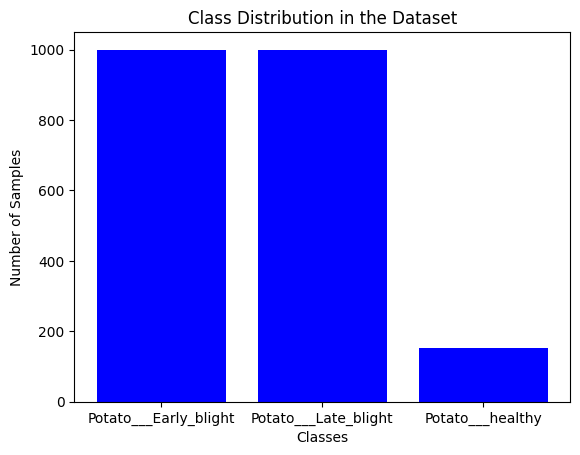

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Access the class names from the dataset
class_names = dataset.class_names

# Count the number of samples in each class
class_counts = [0] * len(class_names)
for _, labels in dataset:
    for label in labels.numpy():
        class_counts[label] += 1

# Plot the bar chart
plt.bar(class_names, class_counts, color='blue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in the Dataset')
plt.show()


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 0]


### Visualize some of the images

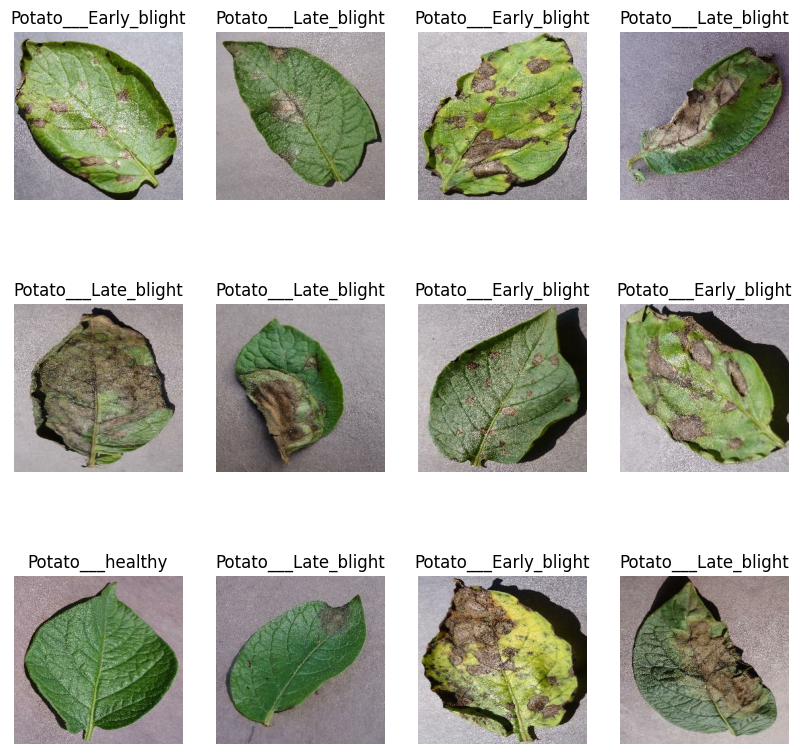

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(2):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(dataset)

135

In [ ]:
train_size = 0.8
len(dataset)*train_size

108.0

In [ ]:
train_ds = dataset.take(54)
len(train_ds)

54

In [ ]:
test_ds = dataset.skip(54)
len(test_ds)

81

In [ ]:
val_size=0.1
len(dataset)*val_size

13.5

In [ ]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [ ]:
test_ds = test_ds.skip(7)
len(test_ds)

74

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

108

In [ ]:
len(val_ds)

13

In [ ]:
len(test_ds)

14

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of the model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (16, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (16, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (16, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (16, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (16, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (16, 60, 60, 64)         

### Compiling the Model
Use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,  # small batch size because of computing power
    validation_data=val_ds,
    verbose=2,
    epochs=EPOCHS,  # Choose a smaller number of epochs
)
'''
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=10
'''

Epoch 1/25
108/108 - 288s - loss: 0.8368 - accuracy: 0.5550 - val_loss: 0.6013 - val_accuracy: 0.7350 - 288s/epoch - 3s/step
Epoch 2/25
108/108 - 259s - loss: 0.4417 - accuracy: 0.8015 - val_loss: 0.3547 - val_accuracy: 0.8450 - 259s/epoch - 2s/step
Epoch 3/25
108/108 - 257s - loss: 0.3505 - accuracy: 0.8605 - val_loss: 0.3675 - val_accuracy: 0.8600 - 257s/epoch - 2s/step
Epoch 4/25
108/108 - 253s - loss: 0.2594 - accuracy: 0.8929 - val_loss: 0.4439 - val_accuracy: 0.8300 - 253s/epoch - 2s/step
Epoch 5/25
108/108 - 254s - loss: 0.3092 - accuracy: 0.8773 - val_loss: 0.4348 - val_accuracy: 0.8400 - 254s/epoch - 2s/step
Epoch 6/25
108/108 - 252s - loss: 0.2228 - accuracy: 0.9161 - val_loss: 0.2192 - val_accuracy: 0.9200 - 252s/epoch - 2s/step
Epoch 7/25
108/108 - 253s - loss: 0.1864 - accuracy: 0.9248 - val_loss: 0.3109 - val_accuracy: 0.8850 - 253s/epoch - 2s/step
Epoch 8/25
108/108 - 254s - loss: 0.1831 - accuracy: 0.9219 - val_loss: 0.3128 - val_accuracy: 0.8850 - 254s/epoch - 2s/step


'\nBATCH_SIZE = 16\nIMAGE_SIZE = 256\nCHANNELS=3\nEPOCHS=10\n'

In [ ]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 19s 594ms/step - loss: 0.0423 - accuracy: 0.9911


In [ ]:
scores

[0.04233115166425705, 0.9910714030265808]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [ ]:
history

In [ ]:
history.params

{'verbose': 2, 'epochs': 25, 'steps': 108}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

25

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8368128538131714,
 0.44169262051582336,
 0.35050156712532043,
 0.2594411075115204,
 0.3092416226863861]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

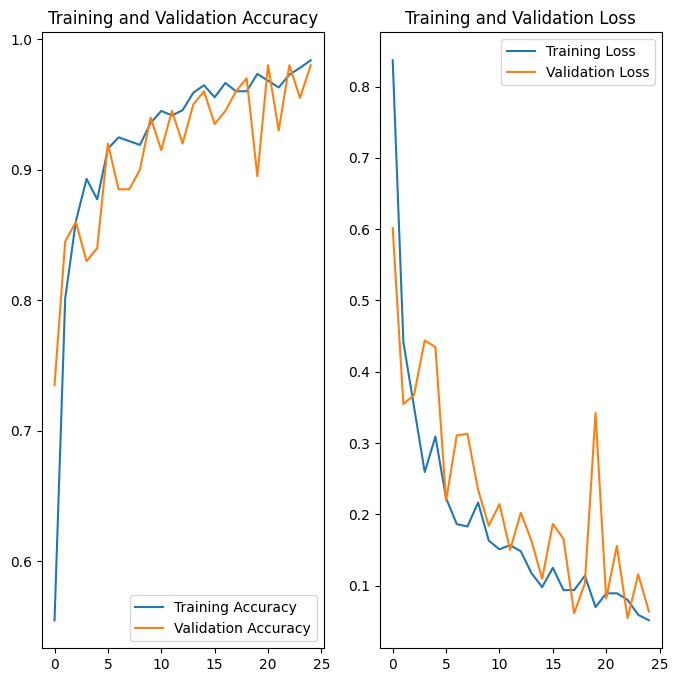

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


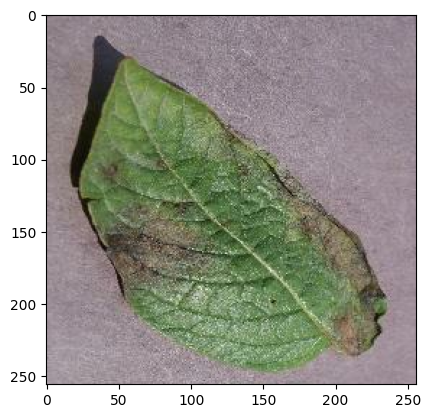

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[2].numpy().astype('uint8')
    first_label = labels_batch[2].numpy()

    print("image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[2])])

### Write a function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 56ms/step


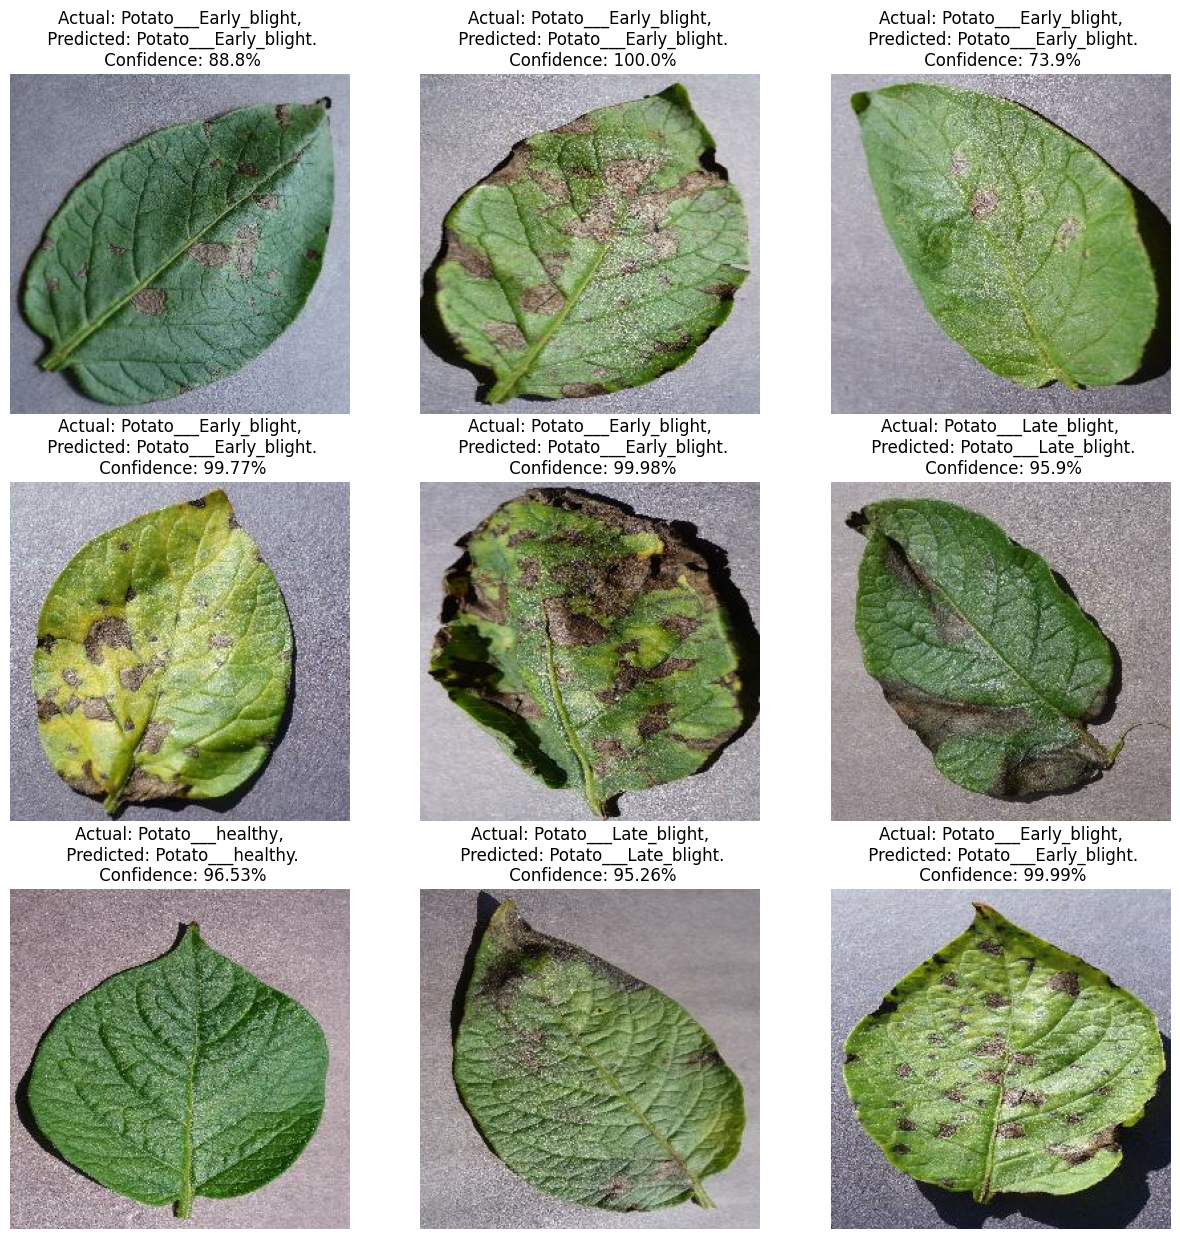

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [ ]:
import os

models_directory = "/content/drive/MyDrive/Bradford/PlantVillageModels"

os.makedirs(models_directory, exist_ok=True)

version_dirs = [i for i in os.listdir(models_directory) if i.isdigit()]

model_version = max([int(i) for i in version_dirs + [0]]) + 1

model.save(os.path.join(models_directory, f'model_{model_version}.keras'))

model.save(os.path.join(models_directory, 'potatoes.keras'))